In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
pip install pydot graphviz

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os


BASE_DIR = "/content/drive/MyDrive/Project/Image Captioning" 

WORKING_DIR = os.path.join(BASE_DIR, "Inception-v3")

os.chdir(WORKING_DIR)



FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Project/Image Captioning/Inception-v3'

In [8]:
WORKING_DIR

'/content/drive/MyDrive/Project/Image Captioning/Inception-v3'

In [4]:
import os


BASE_DIR = "/kaggle/input/flickr8k"

WORKING_DIR = os.getcwd()

print("Working Directory:", WORKING_DIR)
print("Base Directory:", BASE_DIR)

Working Directory: /kaggle/working
Base Directory: /kaggle/input/flickr8k


In [ ]:
pip install tensorflow==1.14

In [ ]:


tf.executing_eagerly()


True

In [5]:
import pickle
import numpy as np
import tensorflow as tf
from tqdm.notebook import tqdm
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Embedding, LSTM, Dropout, Flatten, Input, add
from tensorflow.keras.models import Model
from tensorflow.keras import Sequential
from tensorflow.keras.utils import to_categorical, plot_model

2024-04-30 05:50:16.915268: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-30 05:50:16.915366: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-30 05:50:17.046422: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [7]:
import pandas as pd

captions_df = pd.read_csv(WORKING_DIR + "/Data/captions.txt")

captions_df.head(10)

image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   
5  1001773457_577c3a7d70.jpg   
6  1001773457_577c3a7d70.jpg   
7  1001773457_577c3a7d70.jpg   
8  1001773457_577c3a7d70.jpg   
9  1001773457_577c3a7d70.jpg   

                                             caption  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .  
2   A little girl climbing into a wooden playhouse .  
3  A little girl climbing the stairs to her playh...  
4  A little girl in a pink dress going into a woo...  
5         A black dog and a spotted dog are fighting  
6  A black dog and a tri-colored dog playing with...  
7  A black dog and a white dog with brown spots a...  
8  Two dogs of different breeds looking at each o...  
9    Two dogs on pavement moving toward each other .

In [11]:
import re
for i in captions_df["image"]:
    x = re.search("([^\s]+(\.(?i)(jpg|png|gif|bmp))$)", i)
    if (x):
        pass
    else:
        print(f"YES! We have a match!: {i}")

NameError: name 'captions_df' is not defined

In [8]:
captions_df.caption.values

array(['A child in a pink dress is climbing up a set of stairs in an entry way .',
       'A girl going into a wooden building .',
       'A little girl climbing into a wooden playhouse .', ...,
       'A person in a red shirt climbing up a rock face covered in assist handles .',
       'A rock climber in a red shirt .',
       'A rock climber practices on a rock climbing wall .'], dtype=object)

In [8]:
# Importing InceptionV3 model with pre-trained ImageNet weights
inception_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')

# Getting the input and output layers of the InceptionV3 model
new_input = inception_model.input
hidden_layer = inception_model.layers[-1].output

# Creating a feature extraction model using the input and output layers
image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

# Displaying the summary of the feature extraction model
image_features_extract_model.summary()


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, None,      │        864 │ input_layer[0][0] │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, None,      │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, None,      │          0 │ batch_normalizat… │
│ (Activation)        │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, None,      │      9,216 │ activation[0][0]  │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None,      │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, None,      │          0 │ batch_normalizat… │
│ (Activation)        │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, None,      │     18,432 │ activation_1[0][… │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None,      │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, None,      │          0 │ batch_normalizat… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, None,      │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, None,      │      5,120 │ max_pooling2d[0]… │
│                     │ None, 80)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None,      │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ None, 80)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, None,      │          0 │ batch_normalizat… │
│ (Activation)        │ None, 80)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, None,      │    138,240 │ activation_3[0][… │
│                     │ None, 192)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None,      │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ None, 192)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, None,      │          0 │ batch_normalizat

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 21,768,352 (83.04 MB)

 Non-trainable params: 34,432 (134.50 KB)

In [8]:
os.makedirs('/kaggle/working/flickr8k')

In [12]:
import shutil
shutil.rmtree('/kaggle/working/flickr8k')

In [10]:
import shutil

# Specify the source folder path from the dataset
src_folder = '/kaggle/input/'

# Specify the destination folder path in your working directory
dst_folder = WORKING_DIR + "/Data"

# Copy the folder and its contents to the working directory
shutil.copytree(src_folder, dst_folder)

'/kaggle/working/Data'

In [9]:
BASE_DIR = '/kaggle/working/Data'

In [12]:
dir = BASE_DIR + '/Images'

img_paths = []

for img_name in os.listdir(dir):
    img_path = dir + '/' + img_name
    img_paths.append(img_path)

print(len(img_paths))
print(img_paths[0])

8091
/kaggle/working/Data/Images/166507476_9be5b9852a.jpg


In [ ]:
#from keras.applications.vgg16 import preprocess_input

In [13]:
from tensorflow.keras.applications.inception_v3 import preprocess_input

In [14]:
def load_image(image_path):
    image_path_str = tf.strings.as_string(image_path)  # Convert tensor to string tensor
    image_name = tf.strings.split(tf.strings.split(image_path_str, '/')[-1], '.')[0]  # Extract image name
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = preprocess_input(img)
    return img, image_name

img = load_image(BASE_DIR + '/Images/3582465732_78f77f34ae.jpg')[0]
print(img.shape)


(299, 299, 3)


In [15]:
image_dataset = tf.data.Dataset.from_tensor_slices(img_paths)
image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(64)

print(f"Let's check the BatchDataset shapes--> {image_dataset}")


Let's check the BatchDataset shapes--> <_BatchDataset element_spec=(TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None))>


In [ ]:
image_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None))>

In [ ]:
# %%time
# for img, path in tqdm(image_dataset):
#   batch_features = image_features_extract_model(img)
#   batch_features = tf.reshape(batch_features,
#                               (batch_features.shape[0], -1, batch_features.shape[3]))

#   for bf, p in zip(batch_features, path):
#     path_of_feature = p.numpy().decode("utf-8")
#     np.save(path_of_feature, bf.numpy())

In [ ]:
import shutil

save_dir = 'kaggle/working/Features'

#shutil.rmtree('/kaggle/working/flickr8k')

In [15]:
 os.makedirs('Inception_Features', exist_ok = True)

In [ ]:
os.remove('/kaggle/working/Features/Tensor("args_0:0", shape=(), dtype=string).pkl')

In [ ]:
import shutil

shutil.rmtree('/content/drive/MyDrive/Project/Image Captioning/checkpoint_final')

In [ ]:
# for item in image_dataset.take(1):
#     print(item)

In [16]:
import pickle

save_dir = tf.constant(WORKING_DIR + '/Inception_Features')
save_dir = save_dir.numpy().decode('utf-8')

for img, name in tqdm(image_dataset):
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, image_name in zip(batch_features, name):
    image_feature_name = image_name.numpy().decode('utf-8')
    #image_feature_name = p.numpy().decode('utf-8')
    #full_path = os.path.join(save_dir, image_feature_name)
    #print(save_dir)
    #print(image_feature_name)

    with open(os.path.join(save_dir, image_feature_name + '.pkl'),'wb') as f:
        pickle.dump(bf,f)


  0%|          | 0/127 [00:00<?, ?it/s]

In [16]:
count = 0

save_dir = WORKING_DIR + '/Inception_Features'

for i in os.listdir(save_dir):
    count += 1

print(count)


8091


In [ ]:
tf.data.Dataset.from_tensor_slices?

In [18]:
bf.numpy().shape

(64, 2048)

In [19]:
batch_features.numpy().shape

(27, 64, 2048)

In [20]:
len(captions_df.caption)

40455

In [21]:
len(set(captions_df.image))

8091

In [17]:
def get_name(path):
    name = os.path.basename(path)
    name = name.split('.')[0]
    return name

name = get_name(BASE_DIR + '/Images/2567035103_3511020c8f.jpg')
print(name)

2567035103_3511020c8f


In [18]:
all_captions = []

for caption in captions_df['caption']:
    caption = "<sos> " + caption + " <eos>"
    all_captions.append(caption)

all_captions[:10]

['<sos> A child in a pink dress is climbing up a set of stairs in an entry way . <eos>',
 '<sos> A girl going into a wooden building . <eos>',
 '<sos> A little girl climbing into a wooden playhouse . <eos>',
 '<sos> A little girl climbing the stairs to her playhouse . <eos>',
 '<sos> A little girl in a pink dress going into a wooden cabin . <eos>',
 '<sos> A black dog and a spotted dog are fighting <eos>',
 '<sos> A black dog and a tri-colored dog playing with each other on the road . <eos>',
 '<sos> A black dog and a white dog with brown spots are staring at each other in the street . <eos>',
 '<sos> Two dogs of different breeds looking at each other on the road . <eos>',
 '<sos> Two dogs on pavement moving toward each other . <eos>']

In [19]:
image_names = []

for name in captions_df['image']:
    image_name = get_name(name)
    image_names.append(image_name)

image_names[:10]

['1000268201_693b08cb0e',
 '1000268201_693b08cb0e',
 '1000268201_693b08cb0e',
 '1000268201_693b08cb0e',
 '1000268201_693b08cb0e',
 '1001773457_577c3a7d70',
 '1001773457_577c3a7d70',
 '1001773457_577c3a7d70',
 '1001773457_577c3a7d70',
 '1001773457_577c3a7d70']

In [20]:
from sklearn.utils import shuffle

shuffled_captions, shuffled_image_names = shuffle(all_captions,
                                                  image_names,
                                                  random_state=1)

In [ ]:
#len(shuffled_captions)


In [ ]:
# len(shuffled_image_names)
# shuffled_image_names[:10]

In [21]:
#function for getting maxlen of the caption

def get_maxlen(captions):
    len_caption = []
    for caption in captions_df['caption']:
        len_caption.append(len(caption.split()))

    return max(len_caption)

In [22]:
# utilizing the tokenizer

top_k = 5000
tokenizer = Tokenizer(num_words = top_k, oov_token = '<unk>', filters = '!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')

tokenizer.fit_on_texts(shuffled_captions)

tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

train_seqs = tokenizer.texts_to_sequences(shuffled_captions)

vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)


8498


In [28]:
tokenizer.word_index['<pad>']

0

In [29]:
tokenizer.index_word

'<pad>'

In [ ]:
#tokenizer.word_index

In [23]:
max_length = get_maxlen(train_seqs)
print(max_length)

38


In [24]:
caption_vector = pad_sequences(train_seqs, maxlen = max_length, padding = 'post')
print(caption_vector.shape)

(40455, 38)


In [25]:
# train test split

from sklearn.model_selection import train_test_split

train_image, test_image, train_caption, test_caption = train_test_split(shuffled_image_names,
                                                                        caption_vector,
                                                                       test_size = 0.2,
                                                                       random_state = 0)

In [33]:
len(train_image), len(test_image), len(train_caption), len(test_caption)

(32364, 8091, 32364, 8091)

In [ ]:
train_image[0]

'386655611_1329495f97'

In [34]:
train_caption[0]

array([  3,   6,  28,   9,  15,  10, 354,   2, 297,  56, 128, 125,   6,
        43,   4,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
      dtype=int32)

In [26]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
num_steps = len(train_image) // BATCH_SIZE
features_shape = 2048
attention_features_shape = 64

In [26]:

save_dir = tf.constant(WORKING_DIR + '/Inception_Features')
save_dir = save_dir.numpy().decode('utf-8')

def map_func(image_name, caption):
    name = tf.constant(image_name)
    image_name_str = name.numpy().decode('utf-8')
    with open(os.path.join(str(save_dir), image_name_str + ".pkl"),'rb') as f:
        img_tensor = pickle.load(f)
    return img_tensor, caption

tensor, cap = map_func(train_image[0], train_caption[0])
print(tensor)
print(cap)


tf.Tensor(
[[0.         0.         0.         ... 0.         0.         0.43418586]
 [0.         0.         0.         ... 0.         0.07740025 0.61409366]
 [0.         0.         0.         ... 0.         1.9210111  0.5126506 ]
 ...
 [0.5970091  0.         0.18619165 ... 0.         0.         0.        ]
 [0.         0.19068968 0.         ... 0.00338417 0.         0.        ]
 [0.         0.         0.         ... 0.24609661 0.         0.        ]], shape=(64, 2048), dtype=float32)
[  3   6  28   9  15  10 354   2 297  56 128 125   6  43   4   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0]


In [ ]:
# for i in os.listdir(features_dir):
#     name = i.split('.')[0]
#     if name == train_image[0]:
#         print("found")
#         break
#     else:
#         continue



In [27]:

dataset = tf.data.Dataset.from_tensor_slices((train_image, train_caption))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [44]:
for item in dataset.take(1):
    print(item)

(<tf.Tensor: shape=(64, 64, 2048), dtype=float32, numpy=

array([[[ 0.       ,  0.       , 35.910877 , ...,  9.897114 ,

          0.       , 18.198814 ],

        [ 0.       ,  0.       , 83.06581  , ...,  8.898789 ,

          0.       ,  5.4114537],

        [ 0.       ,  0.       , 49.262775 , ..., 13.2945   ,

          0.       ,  0.       ],

        ...,

        [ 0.       ,  0.       , 57.064903 , ...,  0.       ,

          0.       ,  0.       ],

        [ 0.       ,  0.       , 22.260454 , ...,  0.       ,

         10.101948 ,  0.       ],

        [ 0.       ,  0.       , 32.178963 , ...,  0.       ,

         45.18004  ,  0.       ]],



       [[ 0.       ,  0.       ,  0.       , ...,  0.       ,

          0.       ,  0.       ],

        [ 0.       ,  9.756074 ,  0.       , ...,  0.       ,

          0.       ,  0.       ],

        [ 0.       ,  0.       ,  0.       , ...,  0.       ,

          0.       ,  0.       ],

        ...,

        [ 0.       ,  0.     

In [45]:
len(dataset)

506

In [ ]:
tf.data.experimental.enable_debug_mode()

# Model


In [27]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # score shape == (batch_size, 64, hidden_size)
    score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))

    # attention_weights shape == (batch_size, 64, 1)
    # you get 1 at the last axis because you are applying score to self.V
    attention_weights = tf.nn.softmax(self.V(score), axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.lstm = tf.keras.layers.LSTM(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state, c_state = self.lstm(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [28]:
# BATCH_SIZE = 64
# BUFFER_SIZE = 1000
# embedding_dim = 256
# units = 512
# num_steps = len(train_image) // BATCH_SIZE
# features_shape = 2048
# attention_features_shape = 64

encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [ ]:
encoder.summary()

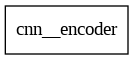

In [ ]:
import tensorflow as tf

# Plot the CNN Encoder model
tf.keras.utils.plot_model(encoder, to_file='encoder_model.png', show_shapes=True)


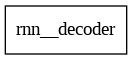

In [ ]:
# Plot the RNN Decoder model

tf.keras.utils.plot_model(decoder, to_file='decoder_model.png', show_shapes=True)


In [ ]:
decoder.summary()

In [29]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [33]:
# saving checkpoint

checkpoint_path_ckpt = WORKING_DIR + "/checkpoint_final/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path_ckpt, max_to_keep=5)

In [35]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

In [36]:
print(start_epoch)

8


# Training

In [55]:
# Function to save the entire model
def save_model(encoder, decoder):
    tf.saved_model.save(encoder, ckpt_manager.save_checkpoint_path)
    tf.saved_model.save(encoder, ckpt_manager.save_checkpoint_path)


In [53]:
import time

loss_plot = []

@tf.function
def train_step(img_tensor, target):
    loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
    hidden = decoder.reset_state(batch_size=target.shape[0])

    dec_input = tf.expand_dims([tokenizer.word_index['<sos>']] * target.shape[0], 1)

    with tf.GradientTape() as tape:
        features = encoder(img_tensor)

        for i in range(1, target.shape[1]):
            # passing the features through the decoder
            predictions, hidden, _ = decoder(dec_input, features, hidden)

            loss += loss_function(target[:, i], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(target[:, i], 1)

        total_loss = (loss / int(target.shape[1]))

        trainable_variables = encoder.trainable_variables + decoder.trainable_variables

        gradients = tape.gradient(loss, trainable_variables)

        optimizer.apply_gradients(zip(gradients, trainable_variables))

        return loss, total_loss


EPOCHS = 20

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
        ckpt_manager.save()
        

    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))


/opt/conda/lib/python3.10/site-packages/keras/src/optimizers/base_optimizer.py:576: UserWarning: Gradients do not exist for variables ['kernel', 'kernel', 'kernel', 'bias', 'kernel'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


Epoch 5 Batch 0 Loss 0.4994
Epoch 5 Batch 100 Loss 0.7698
Epoch 5 Batch 200 Loss 0.7015
Epoch 5 Batch 300 Loss 0.6338
Epoch 5 Batch 400 Loss 0.6341
Epoch 5 Batch 500 Loss 0.7122
Epoch 5 Loss 0.730321
Time taken for 1 epoch 142.77979516983032 sec

Epoch 6 Batch 0 Loss 0.4953
Epoch 6 Batch 100 Loss 0.5292
Epoch 6 Batch 200 Loss 0.5192
Epoch 6 Batch 300 Loss 0.5189
Epoch 6 Batch 400 Loss 0.4633
Epoch 6 Batch 500 Loss 0.4775
Epoch 6 Loss 0.516027
Time taken for 1 epoch 97.68556499481201 sec

Epoch 7 Batch 0 Loss 0.4487
Epoch 7 Batch 100 Loss 0.4472
Epoch 7 Batch 200 Loss 0.4158
Epoch 7 Batch 300 Loss 0.4538
Epoch 7 Batch 400 Loss 0.4587
Epoch 7 Batch 500 Loss 0.3899
Epoch 7 Loss 0.445859
Time taken for 1 epoch 98.28798794746399 sec

Epoch 8 Batch 0 Loss 0.4184
Epoch 8 Batch 100 Loss 0.4001
Epoch 8 Batch 200 Loss 0.4303
Epoch 8 Batch 300 Loss 0.4183
Epoch 8 Batch 400 Loss 0.3896
Epoch 8 Batch 500 Loss 0.4089
Epoch 8 Loss 0.404854
Time taken for 1 epoch 97.02493929862976 sec

Epoch 9 Batch 0

In [38]:
start_epoch = 21

In [43]:
import time

loss_plot = []

@tf.function
def train_step(img_tensor, target):
    loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
    hidden = decoder.reset_state(batch_size=target.shape[0])

    dec_input = tf.expand_dims([tokenizer.word_index['<sos>']] * target.shape[0], 1)

    with tf.GradientTape() as tape:
        features = encoder(img_tensor)

        for i in range(1, target.shape[1]):
            # passing the features through the decoder
            predictions, hidden, _ = decoder(dec_input, features, hidden)

            loss += loss_function(target[:, i], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(target[:, i], 1)

        total_loss = (loss / int(target.shape[1]))

        trainable_variables = encoder.trainable_variables + decoder.trainable_variables

        gradients = tape.gradient(loss, trainable_variables)

        optimizer.apply_gradients(zip(gradients, trainable_variables))

        return loss, total_loss


EPOCHS = 40

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
        ckpt_manager.save()
        

    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))


Epoch 22 Batch 0 Loss 0.2898
Epoch 22 Batch 100 Loss 0.2439
Epoch 22 Batch 200 Loss 0.2354
Epoch 22 Batch 300 Loss 0.2456
Epoch 22 Batch 400 Loss 0.1944
Epoch 22 Batch 500 Loss 0.2411
Epoch 22 Loss 0.223200
Time taken for 1 epoch 141.20868396759033 sec

Epoch 23 Batch 0 Loss 0.2660
Epoch 23 Batch 100 Loss 0.2448
Epoch 23 Batch 200 Loss 0.2104
Epoch 23 Batch 300 Loss 0.2355
Epoch 23 Batch 400 Loss 0.2281
Epoch 23 Batch 500 Loss 0.2023
Epoch 23 Loss 0.215710
Time taken for 1 epoch 95.66867160797119 sec

Epoch 24 Batch 0 Loss 0.3089
Epoch 24 Batch 100 Loss 0.2022
Epoch 24 Batch 200 Loss 0.2108
Epoch 24 Batch 300 Loss 0.2045
Epoch 24 Batch 400 Loss 0.2052
Epoch 24 Batch 500 Loss 0.1827
Epoch 24 Loss 0.211642
Time taken for 1 epoch 95.72784876823425 sec

Epoch 25 Batch 0 Loss 0.2922
Epoch 25 Batch 100 Loss 0.2117
Epoch 25 Batch 200 Loss 0.1982
Epoch 25 Batch 300 Loss 0.2026
Epoch 25 Batch 400 Loss 0.2098
Epoch 25 Batch 500 Loss 0.1822
Epoch 25 Loss 0.205816
Time taken for 1 epoch 95.5759534

In [44]:
ckpt_manager.save()

'/kaggle/working/checkpoint_final/train/ckpt-12'

In [45]:
with open(WORKING_DIR + '/loss_plot.pkl','wb') as f:
    pickle.dump(loss_plot, f)

In [36]:
checkpoint_path_ckpt = WORKING_DIR + "/checkpoint_final/train"

checkpoint_path = checkpoint_path_ckpt
#tf.compat.v2.keras.callbacks.ModelCheckpoint
ckpt = tf.train.Checkpoint(encoder=encoder,
                               decoder=decoder,
                               optimizer = optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path_ckpt, max_to_keep=5)

if ckpt_manager.latest_checkpoint:
    # Restore the latest checkpoint
    ckpt.restore(ckpt_manager.latest_checkpoint)


In [30]:
with open(WORKING_DIR + '/loss_plot.pkl', 'rb') as f:
    loss_plot = pickle.load(f)

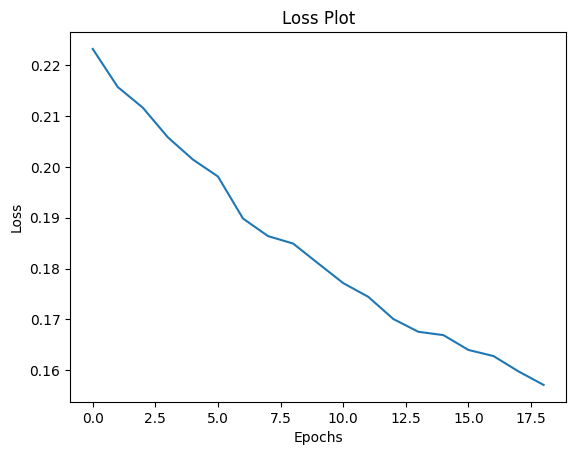

In [46]:
import matplotlib.pyplot as plt

plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

In [31]:
import json
from glob import glob
from PIL import Image

def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

#     img_path = tf.constant(BASE_DIR + '/Images/' + image)
#     print(img_path)
#     img = load_image(img_path)[0]

#     temp_input = tf.expand_dims(img, 0)
#     img_tensor_val = image_features_extract_model(temp_input)

    name = image.split('.')[0]

    with open(WORKING_DIR + '/Inception_Features/' + name + ".pkl","rb") as t:
        img_tensor_val = pickle.load(t)
        
    #img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<sos>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<eos>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [32]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(os.path.join(BASE_DIR, 'Images',image)))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    #plt.tight_layout()
    plt.show()

In [33]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def predict_caption(image):
  real_caption = ' '.join([tokenizer.index_word[i] for i in test_caption[rid] if i not in [0]])
  result, attention_plot = evaluate(image)

  for i in result:
      if i=="<unk>":
          result.remove(i)

  print ('Real Caption:', real_caption)
  print ('Prediction Caption:', ' '.join(result))
  plot_attention(image, result, attention_plot)
  # opening the image
  #Image.open(os.path.join(WORKING_DIR, 'Images', image + ".jpg"))
  path = os.path.join(BASE_DIR, 'Images', image)
  img = mpimg.imread(path)
  plt.imshow(img)


tf.Tensor(b'/kaggle/working/Data/Images/3576312396_799c873f3e.jpg', shape=(), dtype=string)
Real Caption: <sos> a group of people race with boats <eos>
Prediction Caption: many people in boats racing across the ocean <eos>


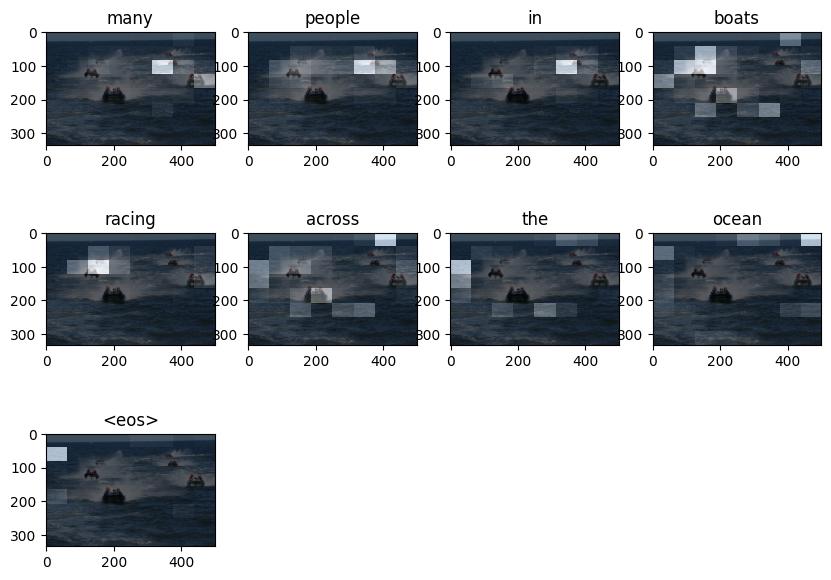

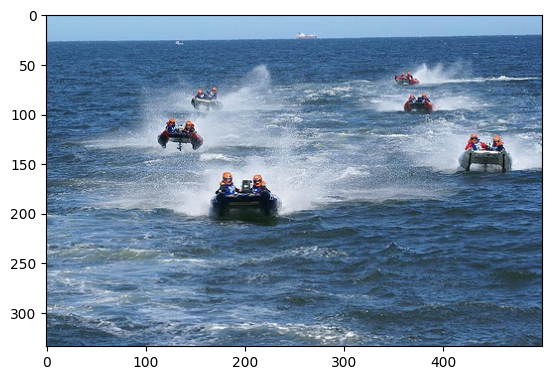

In [78]:
rid = np.random.randint(0, len(test_image))
image = test_image[rid] + '.jpg'

predict_caption(image)

In [75]:
rid = np.random.randint(0, len(test_image))
image = test_image[rid] + '.jpg'

predict_caption(image)

NameError: name 'predict_caption' is not defined

tf.Tensor(b'/kaggle/input/Images/1626754053_81126b67b6.jpg', shape=(), dtype=string)
Real Caption: <sos> a dog about to jump to catch a frisbee <eos>
Prediction Caption: a black and white dog is jumping over an attempt to catch a frisbee <eos>


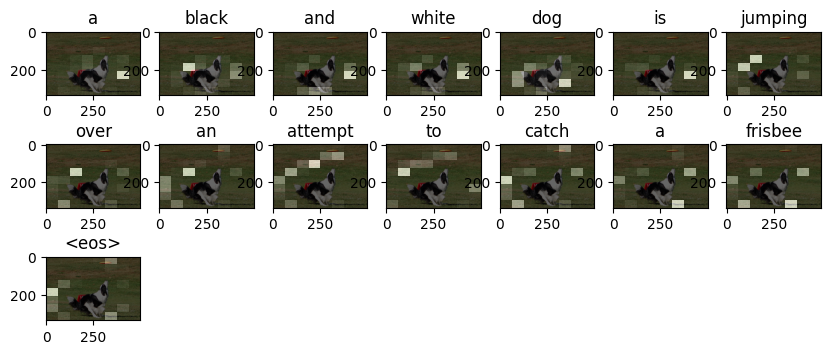

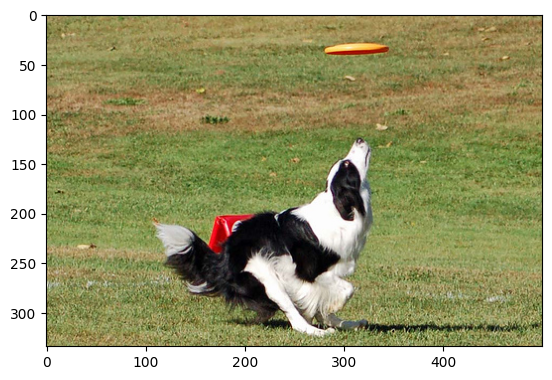

In [54]:
rid = np.random.randint(0, len(test_image))
image = test_image[rid] + '.jpg'

predict_caption(image)

tf.Tensor(b'/kaggle/working/Data/Images/1094462889_f9966dafa6.jpg', shape=(), dtype=string)
Real Caption: <sos> a tan dog stand in the snow and looks up <eos>
Prediction Caption: a dog running through the deep snow <eos>


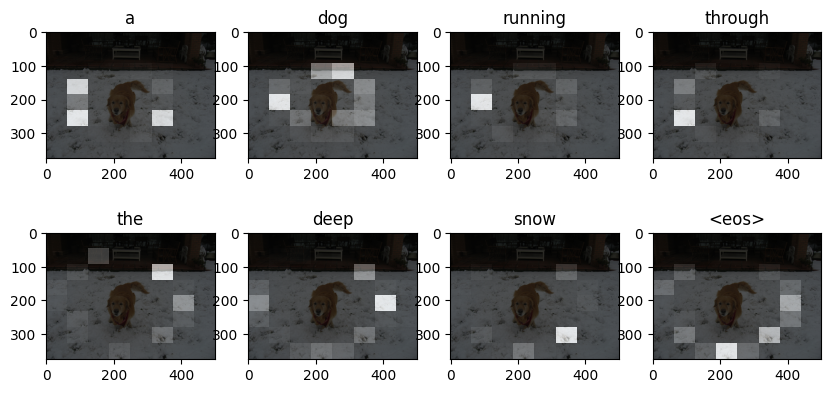

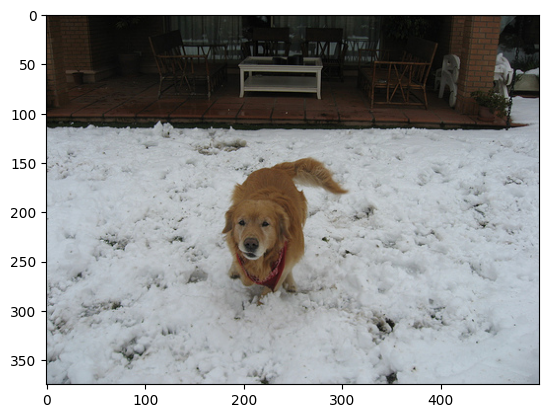

In [79]:
rid = np.random.randint(0, len(test_image))
image = test_image[rid] + '.jpg'

predict_caption(image)

Real Caption: <sos> a child in white shorts and a blue shirt is standing in the street <eos>
Prediction Caption: a boy in shorts stands in the street <eos>


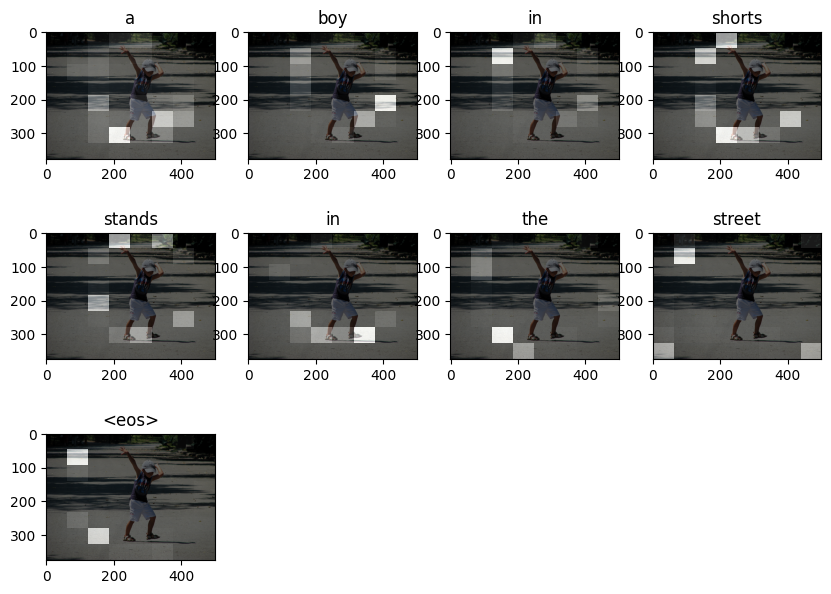

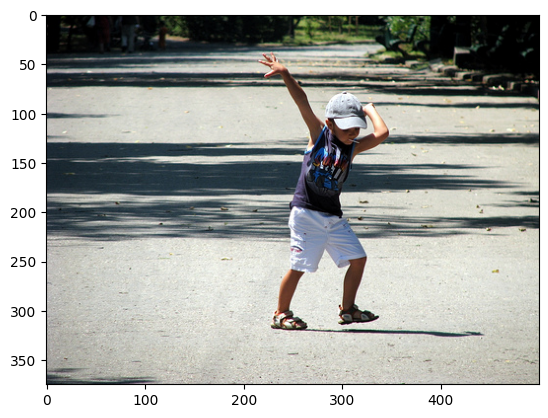

In [140]:
rid = np.random.randint(0, len(test_image))
image = test_image[rid] + '.jpg'

predict_caption(image)


Real Caption: <sos> a boy with <unk> gets ready to jump in the pool <eos>
Prediction Caption: a young boy wearing red floaties about to jump into a pool <eos>


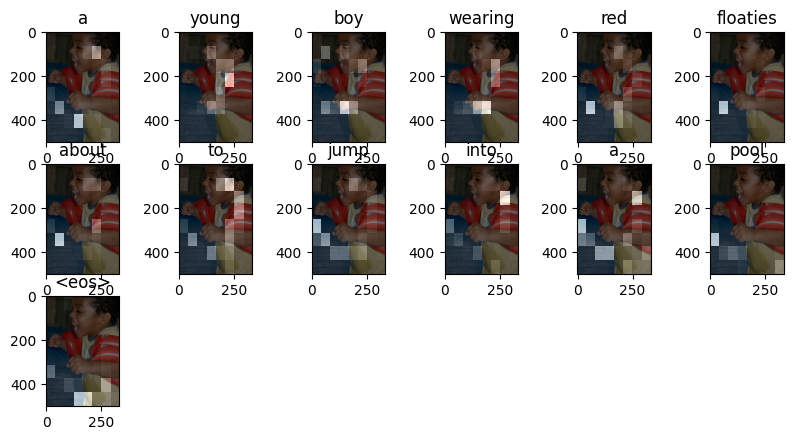

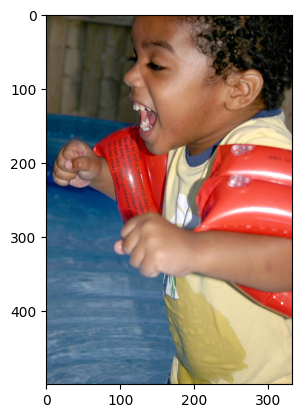

In [50]:
rid = np.random.randint(0, len(test_image))
image = test_image[rid] + '.jpg'

predict_caption(image)

Real Caption: <sos> man wearing hat cardigan and tie in a crowd of people <eos>
Prediction Caption: a man in a blue dress is surrounded by people <eos>


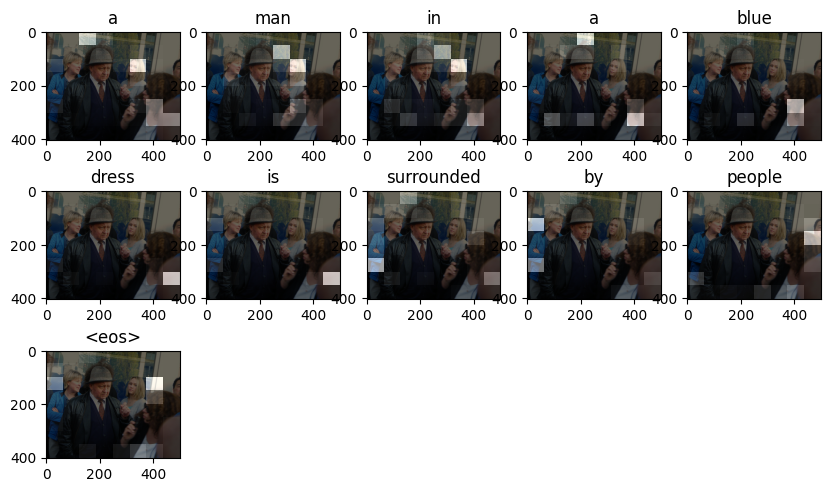

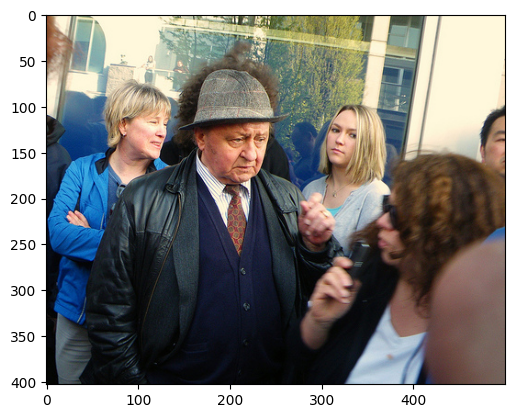

In [51]:
rid = np.random.randint(0, len(test_image))
image = test_image[rid] + '.jpg'

predict_caption(image)

Real Caption: <sos> a small black and white dog jumps with an object in its mouth <eos>
Prediction Caption: a black and white dog is catching a frisbee in its mouth <eos>


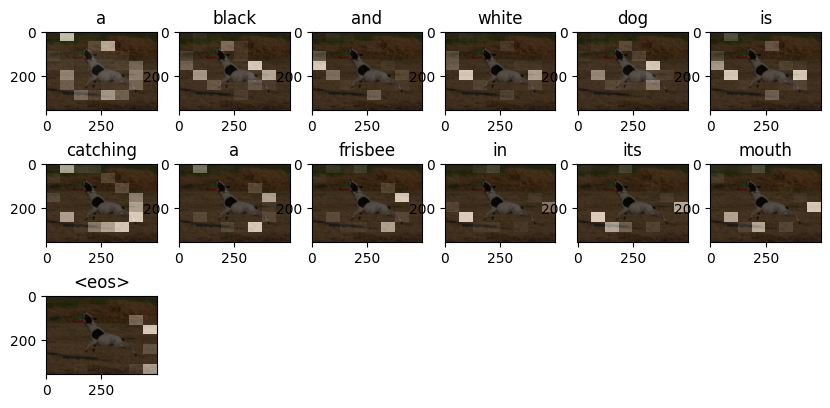

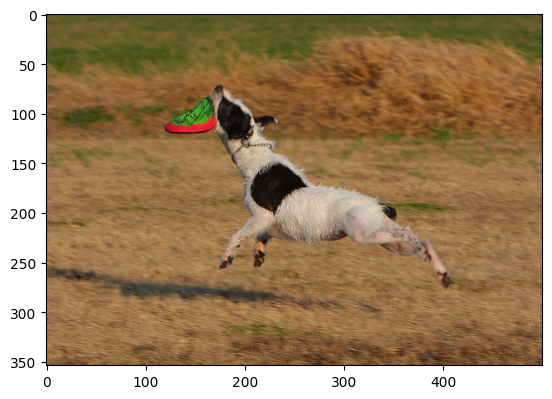

In [52]:
rid = np.random.randint(0, len(test_image))
image = test_image[rid] + '.jpg'

predict_caption(image)

Real Caption: <sos> a dog with a red object in its mouth is hurrying down a smooth path near grass and another dog <eos>
Prediction Caption: a black and white dog is standing on the snow with its paws outstretched <eos>


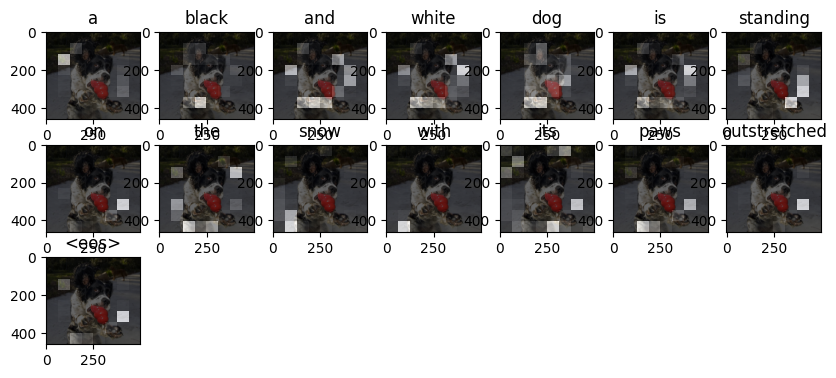

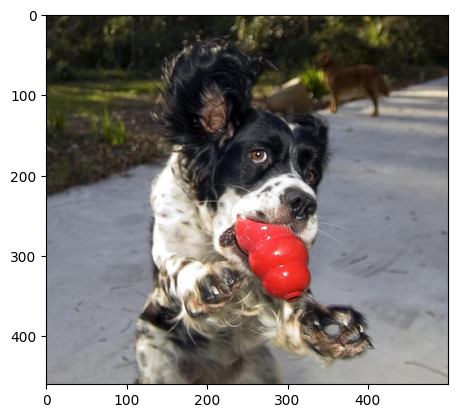

In [57]:
rid = np.random.randint(0, len(test_image))
image = test_image[rid] + '.jpg'

predict_caption(image)

Real Caption: <sos> a motocross rider is slightly airborne on a competition circuit jump <eos>
Prediction Caption: a person is driving a dirt bike is jumping through a bicycle <eos>


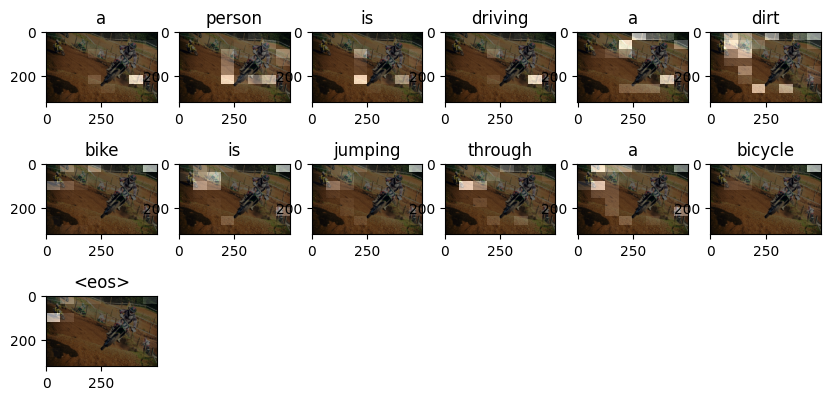

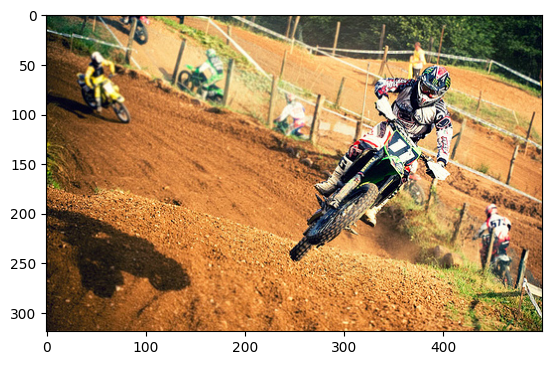

In [66]:
rid = np.random.randint(0, len(test_image))
image = test_image[rid] + '.jpg'

predict_caption(image)

Real Caption: <sos> a lady in winter wear carrying a purse walks down the sidewalk <eos>
Prediction Caption: a woman wearing gray blue jeans is jumping a small child while she walks through sidewalk <eos>


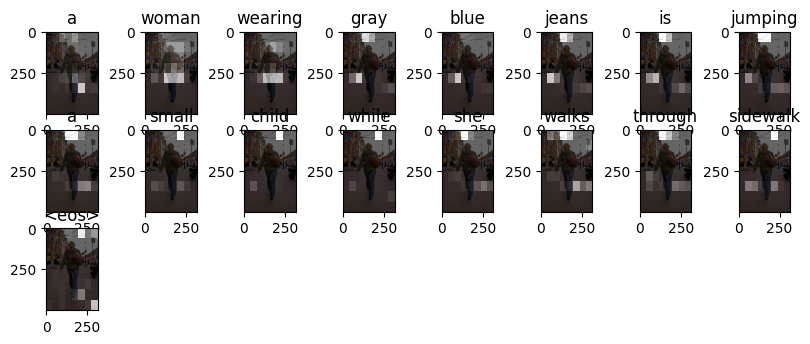

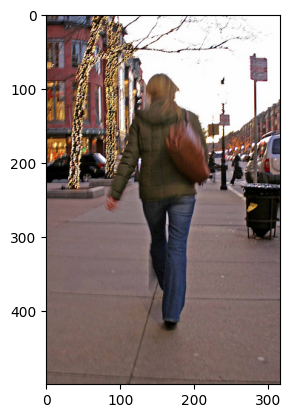

In [67]:
rid = np.random.randint(0, len(test_image))
image = test_image[rid] + '.jpg'

predict_caption(image)

Real Caption: <sos> there man on top of an snow covered mountain with a lake behind him <eos>
Prediction Caption: a <eos>


ValueError: num must be an integer with 1 <= num <= 1, not 2

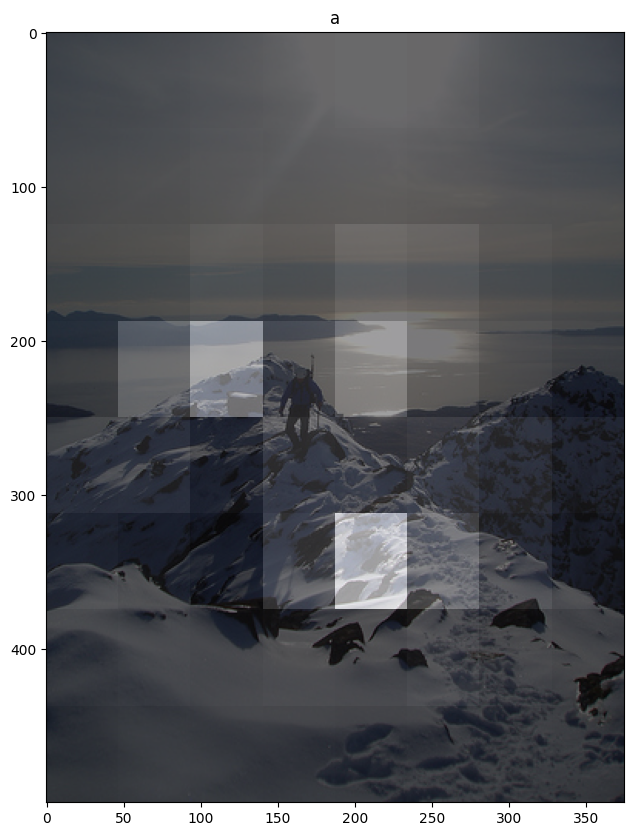

In [35]:
rid = np.random.randint(0, len(test_image))
image = test_image[rid] + '.jpg'

predict_caption(image)

In [ ]:
from nltk.translate.bleu_score import sentence_bleu
reference = [['this', 'a', 'test','of', 'cricket', 'match']]
candidate = ['this', 'is', 'a', 'test','of', 'cricket', 'match']
print('Individual 1-gram: %f' % sentence_bleu(reference, candidate, weights=(1, 0, 0, 0)))
print('Individual 2-gram: %f' % sentence_bleu(reference, candidate, weights=(0, 1, 0, 0)))
print('Individual 3-gram: %f' % sentence_bleu(reference, candidate, weights=(0, 0, 1, 0)))
print('Individual 4-gram: %f' % sentence_bleu(reference, candidate, weights=(0, 0, 0, 1)))

Individual 1-gram: 0.857143

Individual 2-gram: 0.666667

Individual 3-gram: 0.600000

Individual 4-gram: 0.500000


tf.Tensor(b'/kaggle/working/Data/Images/3621647714_fc67ab2617.jpg', shape=(), dtype=string)
BLEU score: 0.15911145683514602
Real Caption: a man standing in snow with a mountain in the background
Prediction Caption: a person stands on snow and looks out at mountains and a snow covered mountains


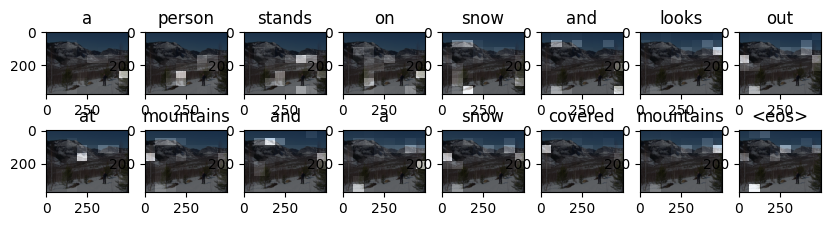

time took to Predict: 3 sec


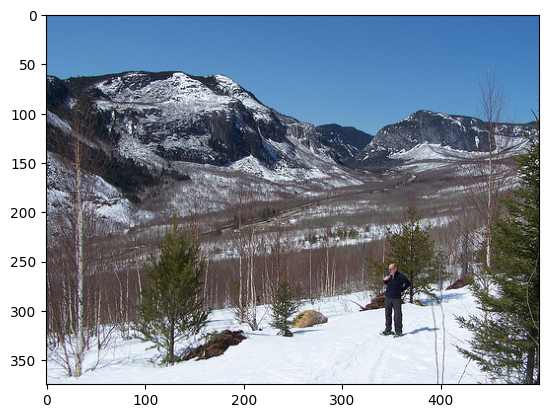

In [81]:
from nltk.translate.bleu_score import sentence_bleu
import time

rid = np.random.randint(0, len(test_image))
image = test_image[rid] + '.jpg'

start = time.time()
real_caption = ' '.join([tokenizer.index_word[i] for i in test_caption[rid] if i not in [0]])
result, attention_plot = evaluate(image)


first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]

#remove "<unk>" in result
for i in result:
    if i=="<unk>":
        result.remove(i)


#remove <end> from result
result_join = ' '.join(result)
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = result_final
score = sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0))
print(f"BLEU score: {score}")

print ('Real Caption:', real_caption)
print ('Prediction Caption:', result_final)
plot_attention(image, result, attention_plot)

print(f"time took to Predict: {round(time.time()-start)} sec")
# opening the image
path = os.path.join(BASE_DIR, 'Images', image)
img = mpimg.imread(path)
plt.imshow(img)

tf.Tensor(b'/kaggle/working/Data/Images/2977379863_2e8d7a104e.jpg', shape=(), dtype=string)
BLEU score: 0
Real Caption: children in costumes standing in line
Prediction Caption: a girl in a black cape with a group of other children


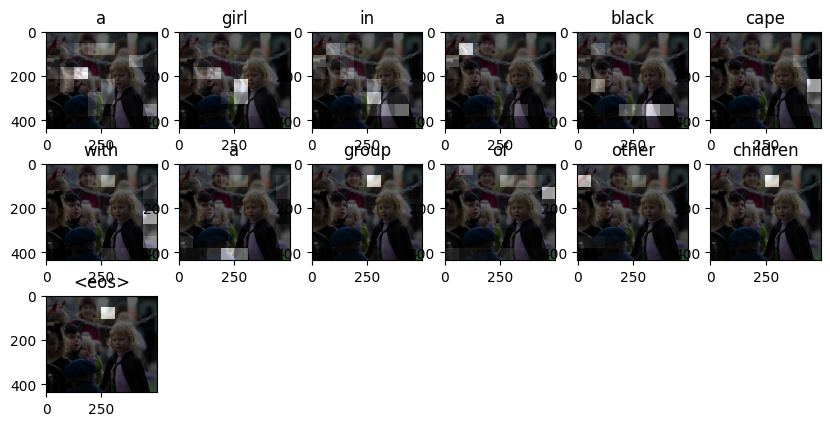

time took to Predict: 3 sec


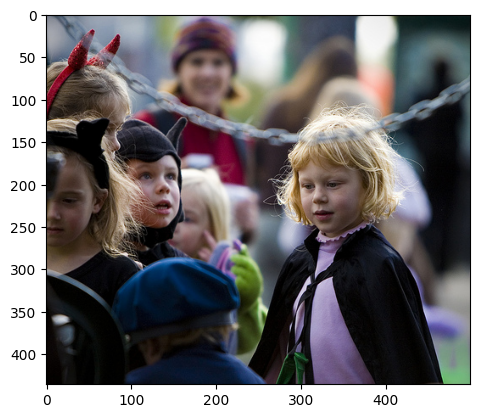

In [82]:
from nltk.translate.bleu_score import sentence_bleu
import time

rid = np.random.randint(0, len(test_image))
image = test_image[rid] + '.jpg'

start = time.time()
real_caption = ' '.join([tokenizer.index_word[i] for i in test_caption[rid] if i not in [0]])
result, attention_plot = evaluate(image)


first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]

#remove "<unk>" in result
for i in result:
    if i=="<unk>":
        result.remove(i)


#remove <end> from result
result_join = ' '.join(result)
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = result_final
score = sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0))
print(f"BLEU score: {score*100}")

print ('Real Caption:', real_caption)
print ('Prediction Caption:', result_final)
plot_attention(image, result, attention_plot)

print(f"time took to Predict: {round(time.time()-start)} sec")
# opening the image
path = os.path.join(BASE_DIR, 'Images', image)
img = mpimg.imread(path)
plt.imshow(img)

BLEU score: 0
Real Caption: an <unk> is submerged in water almost to the door handles
Prediction Caption: a land rover is being driven across a river


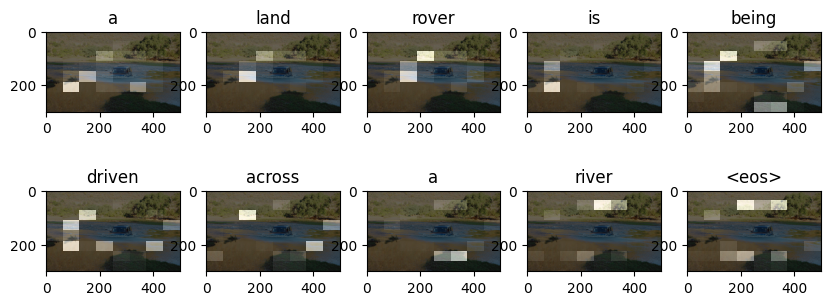

time took to Predict: 2 sec


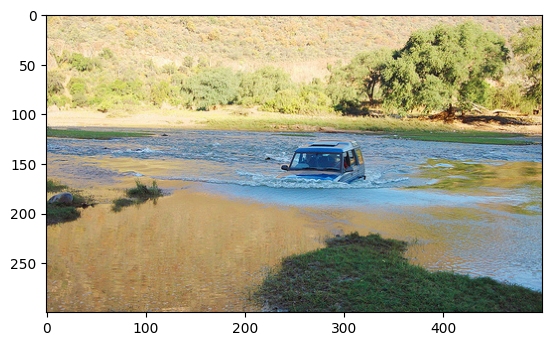

In [68]:
from nltk.translate.bleu_score import sentence_bleu
import time

rid = np.random.randint(0, len(test_image))
image = test_image[rid] + '.jpg'

start = time.time()
real_caption = ' '.join([tokenizer.index_word[i] for i in test_caption[rid] if i not in [0]])
result, attention_plot = evaluate(image)


first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]

#remove "<unk>" in result
for i in result:
    if i=="<unk>":
        result.remove(i)


#remove <end> from result
result_join = ' '.join(result)
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = result_final
score = sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0))
print(f"BLEU score: {score*100}")

print ('Real Caption:', real_caption)
print ('Prediction Caption:', result_final)
plot_attention(image, result, attention_plot)

print(f"time took to Predict: {round(time.time()-start)} sec")
# opening the image
path = os.path.join(BASE_DIR, 'Images', image)
img = mpimg.imread(path)
plt.imshow(img)

Real Caption: <sos> two people wear life jackets in a rowboat <eos>
Prediction Caption: a man and a woman sitting in a rowboat on calm water <eos>


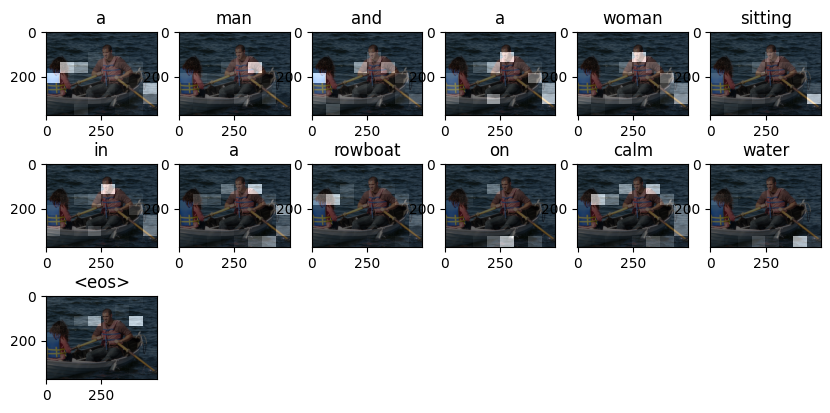

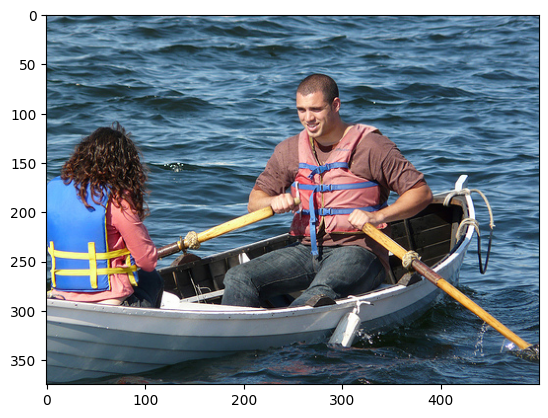

In [104]:
rid = np.random.randint(0, len(test_image))
image = test_image[rid] + '.jpg'

predict_caption(image)

In [ ]:
from IPython.display import FileLink
FileLink(r'file.zip')

/kaggle/working/file.zip

In [ ]:
import zipfile
import os
from IPython.display import FileLink

def zip_dir(directory = os.path.join(WORKING_DIR), file_name = 'Features.zip'):
    """
    zip all the files in a directory

    Parameters
    _____
    directory: str
        directory needs to be zipped, defualt is current working directory

    file_name: str
        the name of the zipped file (including .zip), default is 'directory.zip'

    Returns
    _____
    Creates a hyperlink, which can be used to download the zip file)
    """
    os.chdir(directory)
    zip_ref = zipfile.ZipFile(file_name, mode='w')
    for folder, _, files in os.walk(directory):
        for file in files:
            if file_name in file:
                pass
            else:
                zip_ref.write(os.path.join(folder, file))

    return FileLink(file_name)


In [68]:
#!zip -r file.zip /kaggle/working/Features

In [72]:
# reading captions
import os 

with open(os.path.join(BASE_DIR,"captions.txt"),"r") as c:
  next(c)
  read_captions = c.read() # reading the file 'captions.txt' into read_captions

In [73]:
# creating mapping of image to their captions

from tqdm.notebook import tqdm

def create_mapping(doc):
  mapping = {}

  for line in tqdm(doc.split("\n")):
    if len(line) < 2:
      continue
    words = line.split(",")
    img_name = words[0]
    image_id = img_name.split(".")[0]

    caption = words[1:]
    caption = " ".join(caption)

    if image_id not in mapping:
      mapping[image_id] = []

    mapping[image_id].append(caption)

  return mapping

mapping = create_mapping(read_captions)


  0%|          | 0/40456 [00:00<?, ?it/s]

In [74]:
import pickle

with open(os.path.join(WORKING_DIR,'mapping.pkl'),'wb') as f:
    pickle.dump(mapping, f)

In [34]:
mapping['3329793486_afc16663cc']

['A man on a snowboard is grinding a ramp .',
 'a skier on a snowy ski jump',
 'A snowboarder is riding down a ramp amidst snow .',
 'A snowboarder prepares to go over a ramp .',
 'Snowboarding practice on a snowy hillside']

In [37]:
from sklearn.model_selection import train_test_split

image_ids = list(mapping.keys())

train, test = train_test_split(image_ids, test_size = 0.2, random_state = 42)

In [33]:
import pickle

with open(os.path.join(WORKING_DIR,'mapping.pkl'),'rb') as r:
    mapping = pickle.load(r)

In [35]:

def preprocess(mapping):
  for id,captions in mapping.items():
    for i in range(len(captions)):
      caption = captions[i]
      
      temp = []
      for word in caption.split():
        if len(word) > 1:
          temp.append(word)
      caption = "<SOS> " + ' '.join(temp) + " <EOS>"
      captions[i] = caption

preprocess(mapping)


In [36]:
mapping['3329793486_afc16663cc']

['<SOS> man on snowboard is grinding ramp <EOS>',
 '<SOS> skier on snowy ski jump <EOS>',
 '<SOS> snowboarder is riding down ramp amidst snow <EOS>',
 '<SOS> snowboarder prepares to go over ramp <EOS>',
 '<SOS> Snowboarding practice on snowy hillside <EOS>']

In [46]:
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction


actual, predicted = list(), list()

for key in tqdm(test):
    captions = mapping[key]
    #print(captions)
    
    key = key + ".jpg"
    result, _ = evaluate(key)
    
    for i in result:
      if i=="<unk>":
          result.remove(i)
    
    actual_captions = []
    
        
    for caption in captions:
        cap = list()
        words = caption.split()
        
        for word in words:
            if word in ['<SOS>','<EOS>']:
                continue
            cap.append(word)
        actual_captions.append(cap)
    
    actual.append(actual_captions)
    predicted.append(result)
    
#     print(actual)
#     print(predicted)
   

print("Bleu Score for Image Captioning(Inceptionv3)")

smoothing_function = SmoothingFunction()

print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0), smoothing_function = smoothing_function.method1))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0), smoothing_function = smoothing_function.method1))
    
    

  0%|          | 0/1619 [00:00<?, ?it/s]

Bleu Score for Image Captioning(Inceptionv3)
BLEU-1: 0.505564
BLEU-2: 0.414901


In [112]:
with open(WORKING_DIR + '/actual.pkl','wb') as a:
    pickle.dump(actual, a)
    
with open(WORKING_DIR + '/predicted.pkl','wb') as p:
    pickle.dump(predicted, p)

In [2]:
import pickle

with open(WORKING_DIR + '/actual.pkl','rb') as f:
    actual = pickle.load(f)
    
with open(WORKING_DIR + '/predicted.pkl','rb') as r:
    predicted = pickle.load(r)

In [114]:


from nltk.translate.bleu_score import SmoothingFunction

smoothing_function = SmoothingFunction()

print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0), smoothing_function = smoothing_function.method1))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0), smoothing_function = smoothing_function.method1))

Bleu Score for Image Captioning(Inceptionv3)
BLEU-1: 0.476232
BLEU-2: 0.383529


In [71]:
pip install pyciderevalcap

ERROR: Could not find a version that satisfies the requirement pyciderevalcap (from versions: none)
ERROR: No matching distribution found for pyciderevalcap
Note: you may need to restart the kernel to use updated packages.


In [7]:
from nltk.translate import cider

cider_scorer = cider.Cider()

# Compute CIDEr score
cider_score, _ = cider_scorer.compute_score(actual, predicted)

print("CIDEr score:", cider_score)


ImportError: cannot import name 'cider' from 'nltk.translate' (/opt/conda/lib/python3.10/site-packages/nltk/translate/__init__.py)

In [97]:
actual.pop()
predicted.pop()

len(actual)

1616

In [19]:
pip install nltk


Note: you may need to restart the kernel to use updated packages.


In [76]:
from nltk.translate.bleu_score import corpus_bleu

sent_actual, sent_predicted = list(), list()

for key in tqdm(['2642350864_099c0f2152']):
    captions = mapping[key]
    #print(captions)
    
    key = key + ".jpg"
    result, _ = evaluate(key)
    
    for i in result:
      if i=="<unk>":
          result.remove(i)
            
    #result = ' '.join(result)
    
    #actual_captions = [caption.split() for caption in captions]
    
    all_caps = []
    
    for caption in captions:
        cap = list()
        words = caption.split()
        for word in words:
            if word in ['<SOS>','<EOS>']:
                continue
            cap.append(word)
        all_caps.append(cap)
            
    
    sent_actual.append(all_caps)
    sent_predicted.append(result)
    
    print(sent_actual)
    print(sent_predicted)


  0%|          | 0/1 [00:00<?, ?it/s]

[[['girl', 'smiles', 'while', 'riding', 'on', 'the', 'back', 'of', 'cart', 'in', 'grocery', 'store'], ['little', 'girl', 'is', 'riding', 'on', 'the', 'front', 'of', 'shopping', 'cart', 'in', 'store'], ['little', 'girl', 'wearing', 'blue', 'is', 'riding', 'the', 'end', 'of', 'shopping', 'cart', 'in', 'grocery', 'store'], ['young', 'girl', 'with', 'front', 'tooth', 'missing', 'dressed', 'in', 'plaid', 'skirt', 'and', 'blue', 'shirt', 'riding', 'on', 'shopping', 'cart', 'in', 'grocery', 'store'], ['Girl', 'with', 'brown', 'hair', 'in', 'blue', 'shirt', 'and', 'blue', 'and', 'white', 'skirt', 'holding', 'on', 'to', 'shopping', 'cart', 'in', 'store']]]
[['a', 'little', 'girl', 'smiles', 'while', 'riding', 'on', 'the', 'back', 'of', 'a', 'shopping', 'cart', 'in', 'a', 'grocery', 'store', '<eos>']]


In [77]:
print("BLEU-1: %f" % corpus_bleu(sent_actual, sent_predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(sent_actual, sent_predicted, weights=(0.5, 0.5, 0, 0)))

BLEU-1: 0.735746
BLEU-2: 0.671077


In [6]:
from nltk.translate.meteor_score import meteor_score

score = meteor_score(actual, predicted)

print(score)

TypeError: descriptor 'lower' for 'str' objects doesn't apply to a 'list' object

In [108]:
score = sentence_bleu(sent_actual, sent_predicted, weights=(1.0, 0.0, 0, 0))
print(f"BLEU score: {score}")

BLEU score: 0


In [5]:
!pip install -U nltk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 22.0 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: nltk
    Found existing installation: nltk 3.2.4
    Uninstalling nltk-3.2.4:
      Successfully uninstalled nltk-3.2.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
preprocessing 0.1.13 requires nltk==3.2.4, but you have nltk 3.8.1 which is incompatible.
